In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce
from feature_engine.outlier_removers import Winsorizer
from feature_engine.categorical_encoders import MeanCategoricalEncoder
from feature_engine import variable_transformers as vt

######## Feature selection packages 

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

### models implemented
from catboost import CatBoostRegressor

pd.pandas.set_option('display.max_columns', None)

In [2]:
# load dataset
data = pd.read_csv('houseprice.csv')
### drop the Id 
data = data[['OverallQual', 'ExterQual', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'GarageCars','SalePrice']]
print(data.shape)
data.dtypes.unique()

(1460, 9)


array([dtype('int64'), dtype('O')], dtype=object)

In [3]:
discrete= [ var for var in data.columns   if data[var].dtype != 'O' and var!='SalePrice' and data[var].nunique() < 15 ]
numerical= [ var for var in data.columns     if data[var].dtype != 'O' and var!='SalePrice' and var not in discrete]
categorical = [var for var in data.columns if data[var].dtype =='O']

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} numerical variables'.format(len(numerical)))
print('There are {} categorical variables'.format(len(categorical)))

There are 2 discrete variables
There are 5 numerical variables
There are 1 categorical variables


In [4]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(['SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 8), (146, 8))

In [5]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [6]:
house_pipe = Pipeline([

    # missing data imputation 
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median',
                                        variables= numerical)),
    
    ('imputer_cat', 
     mdi.CategoricalVariableImputer(variables=categorical)),
    
    ##### REMOVE OUTLIERS##############
    ('outlier_rem',
     Winsorizer(distribution='skewed',
                             tail='both',
                             fold=2.0,
                             variables=numerical)),
    ####################################
    # categorical encoding 
    ('rare_label_enc', 
         ce.RareLabelCategoricalEncoder(
        tol=0.05, n_categories=6, variables=categorical+discrete)),
    ('categorical_encoder',
     MeanCategoricalEncoder( variables = categorical + discrete)
    ),
    # regression
    ('regression',
     CatBoostRegressor(max_depth= 6 ,learning_rate=0.01))
]) 

In [7]:
param_grid = {
    'outlier_rem__fold':[1.8,2.0,2.3],
     'rare_label_enc__tol':[0.01,0.05,0.08],
      'rare_label_enc__n_categories':[4,10,13],
      'regression__max_depth':[4,5,6]
    
}

grid_search = GridSearchCV(house_pipe,param_grid,
                          cv=3,iid=False,n_jobs=-1)

In [8]:
# let's fit the pipeline
grid_search.fit(X_train, y_train)

grid_search.score(X_train,y_train)


0:	learn: 78507.8210607	total: 145ms	remaining: 2m 24s
1:	learn: 77983.2246246	total: 146ms	remaining: 1m 13s
2:	learn: 77504.8235390	total: 147ms	remaining: 49s
3:	learn: 77030.8663590	total: 148ms	remaining: 37s
4:	learn: 76540.2603937	total: 150ms	remaining: 29.8s
5:	learn: 76031.6759386	total: 151ms	remaining: 25s
6:	learn: 75571.0385187	total: 152ms	remaining: 21.5s
7:	learn: 75068.3127382	total: 153ms	remaining: 19s
8:	learn: 74593.2340160	total: 154ms	remaining: 17s
9:	learn: 74144.3828455	total: 155ms	remaining: 15.4s
10:	learn: 73686.7165723	total: 156ms	remaining: 14s
11:	learn: 73248.7825479	total: 157ms	remaining: 13s
12:	learn: 72789.1699512	total: 159ms	remaining: 12s
13:	learn: 72350.4966686	total: 160ms	remaining: 11.2s
14:	learn: 71947.8716846	total: 161ms	remaining: 10.6s
15:	learn: 71535.0811414	total: 162ms	remaining: 9.96s
16:	learn: 71096.3655841	total: 163ms	remaining: 9.42s
17:	learn: 70656.9941643	total: 164ms	remaining: 8.95s
18:	learn: 70236.1170892	total: 16

262:	learn: 31919.1117123	total: 480ms	remaining: 1.35s
263:	learn: 31881.7634821	total: 482ms	remaining: 1.34s
264:	learn: 31833.7951786	total: 483ms	remaining: 1.34s
265:	learn: 31799.5380474	total: 485ms	remaining: 1.34s
266:	learn: 31766.4198548	total: 486ms	remaining: 1.33s
267:	learn: 31720.0896439	total: 487ms	remaining: 1.33s
268:	learn: 31684.2025800	total: 488ms	remaining: 1.33s
269:	learn: 31641.4075087	total: 491ms	remaining: 1.33s
270:	learn: 31608.7297578	total: 492ms	remaining: 1.32s
271:	learn: 31571.0746920	total: 493ms	remaining: 1.32s
272:	learn: 31536.4394756	total: 494ms	remaining: 1.32s
273:	learn: 31496.3556807	total: 496ms	remaining: 1.31s
274:	learn: 31456.5154058	total: 497ms	remaining: 1.31s
275:	learn: 31428.7877281	total: 499ms	remaining: 1.31s
276:	learn: 31394.2771764	total: 500ms	remaining: 1.3s
277:	learn: 31357.7444288	total: 501ms	remaining: 1.3s
278:	learn: 31309.9910200	total: 503ms	remaining: 1.3s
279:	learn: 31273.6476087	total: 504ms	remaining: 1

513:	learn: 26642.1845162	total: 806ms	remaining: 762ms
514:	learn: 26631.3696832	total: 807ms	remaining: 760ms
515:	learn: 26622.1445903	total: 808ms	remaining: 758ms
516:	learn: 26609.6647104	total: 809ms	remaining: 756ms
517:	learn: 26599.9952380	total: 811ms	remaining: 754ms
518:	learn: 26593.1978199	total: 812ms	remaining: 752ms
519:	learn: 26587.9892811	total: 813ms	remaining: 750ms
520:	learn: 26574.4394508	total: 814ms	remaining: 748ms
521:	learn: 26562.4458207	total: 815ms	remaining: 747ms
522:	learn: 26548.0268113	total: 816ms	remaining: 745ms
523:	learn: 26535.7556831	total: 817ms	remaining: 743ms
524:	learn: 26519.9906939	total: 819ms	remaining: 741ms
525:	learn: 26511.8745610	total: 820ms	remaining: 739ms
526:	learn: 26498.3819929	total: 821ms	remaining: 737ms
527:	learn: 26486.7315126	total: 822ms	remaining: 735ms
528:	learn: 26474.6109710	total: 823ms	remaining: 733ms
529:	learn: 26469.5821812	total: 825ms	remaining: 731ms
530:	learn: 26456.9643324	total: 826ms	remaining

797:	learn: 24632.0141958	total: 1.13s	remaining: 285ms
798:	learn: 24624.3240044	total: 1.13s	remaining: 284ms
799:	learn: 24617.8639285	total: 1.13s	remaining: 282ms
800:	learn: 24612.5103291	total: 1.13s	remaining: 281ms
801:	learn: 24608.1148401	total: 1.13s	remaining: 279ms
802:	learn: 24605.3035896	total: 1.13s	remaining: 278ms
803:	learn: 24602.9494158	total: 1.13s	remaining: 276ms
804:	learn: 24598.9309589	total: 1.13s	remaining: 275ms
805:	learn: 24596.7485649	total: 1.14s	remaining: 273ms
806:	learn: 24592.8555421	total: 1.14s	remaining: 272ms
807:	learn: 24587.3955440	total: 1.14s	remaining: 271ms
808:	learn: 24585.3275231	total: 1.14s	remaining: 269ms
809:	learn: 24580.5893039	total: 1.14s	remaining: 268ms
810:	learn: 24575.1252595	total: 1.14s	remaining: 266ms
811:	learn: 24571.6136901	total: 1.14s	remaining: 265ms
812:	learn: 24569.2101982	total: 1.14s	remaining: 263ms
813:	learn: 24563.1809919	total: 1.15s	remaining: 262ms
814:	learn: 24558.7275631	total: 1.15s	remaining

0.9089080532102858

In [9]:
grid_search.best_params_

{'outlier_rem__fold': 2.3,
 'rare_label_enc__n_categories': 4,
 'rare_label_enc__tol': 0.01,
 'regression__max_depth': 4}

In [11]:
# let's get the predictions
X_train_preds = grid_search.predict(X_train)
X_test_preds = grid_search.predict(X_test)

In [12]:
# check model performance:           
print('train mae: {}'.format(mean_absolute_error(y_train, X_train_preds) , 2) )
print('train r2: {}'.format(r2_score(y_train, X_train_preds),2))
print()
print('test mae: {}'.format(mean_absolute_error(y_test, X_test_preds),2) )
print('test r2: {}'.format(r2_score(y_test, X_test_preds),2))

train mae: 17310.280937054285
train r2: 0.9089080532102858

test mae: 18580.819395191706
test r2: 0.8680064528206677


Text(0, 0.5, 'Predicted Price')

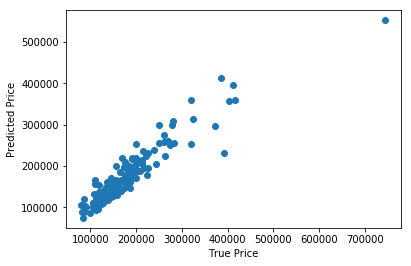

In [13]:
plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')